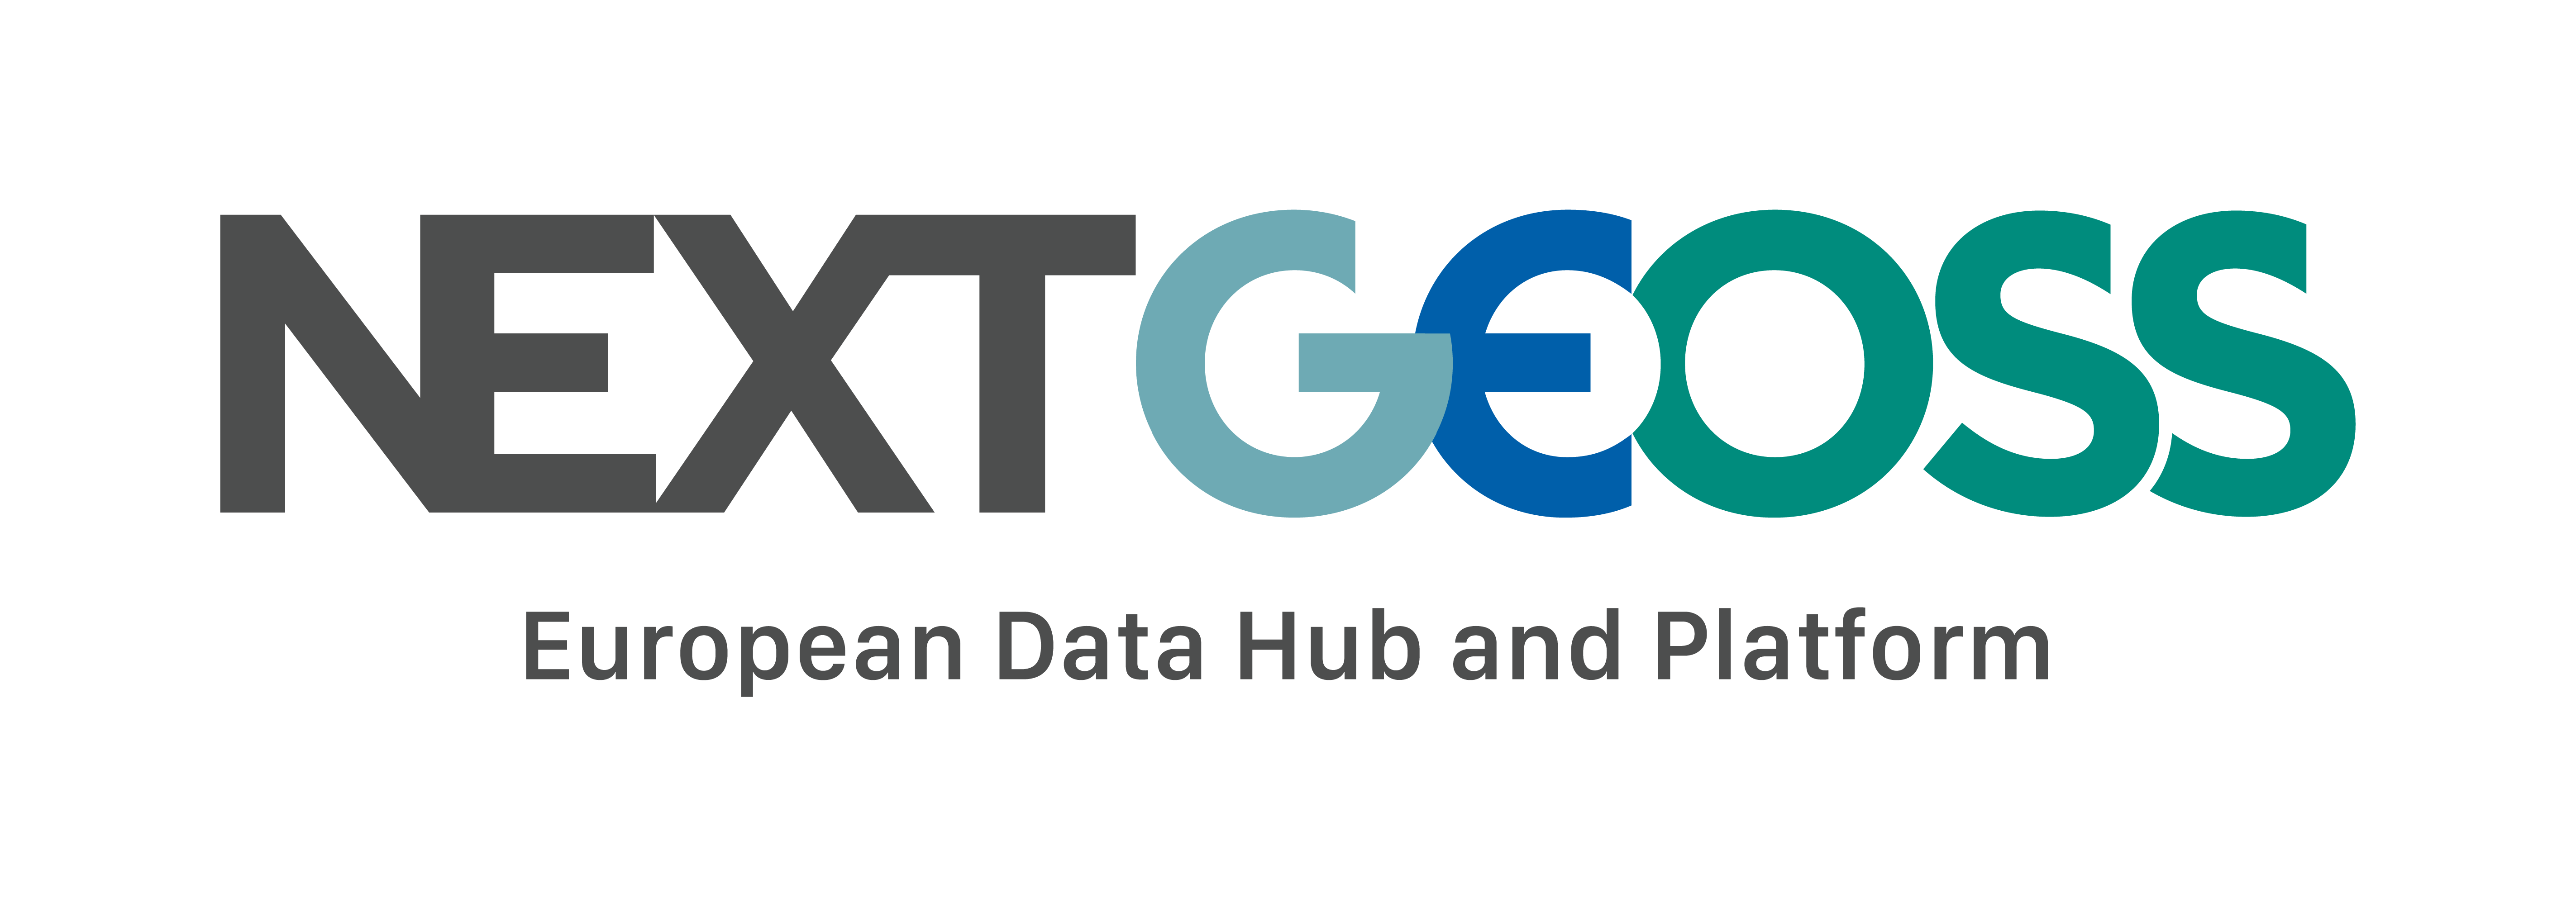

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

PATH = "./img/"
Image(filename = PATH + "NextGEOSS-Logo.png", width=512, height=256)

# NextGEOSS Energy Pilot - Acces time series of gridded data from CAMS Radiation

### This pilot allows to requests for time-series of solar radiation over a regular grid of points covering your area of interest (AOI).

#### GEOGRAPHICAL AREA

Geographical coverage of the CAMS radiation product is the field-of-view of the Meteosat satellite, roughly speaking Europe, Africa, Atlantic Ocean, Middle East (-66° to 66° in both latitudes and longitudes).

#### DATA

The data you request come from CAMS (Copernicus Atmosphere Monitoring Service) Radiation product from a two year time period including the following parameters (Atmosphere optical properties, Ground reflectance, Cloud optical properties, Atmosphere radiative transfer). **#IMPORTANT NOTE: ONLY THE YEARS 2005 AND 2006 ARE AVAILABLE FOR THIS PILOT#**

#### HOW TO REQUEST THE DATA

The resquest to the data is made using an OGC (Open Geospatial COnsortium) standard Web service called WPS (Web Processing Service). This WPS is located remotely on a cloud server and provided as an asynchronous request to the CAMS Radiation process in order to provide you with time series of gridded data on your AOI.

The parameters of the request are first encoded in an url. 

To access the requested data, one must follow a chain of links:
* the first request will return a link to a file that indicates the status of the request (the data being prepared on the server side)
* once the status reach 100%, the same file links to another file
* that files gives the final url that allow one to downloat the data

This notebook will first demonstrate how to build the first url. It will then provide a set of command that fully automate the subsequent "treaure hunt" up to the downloading of the data.

**Please allow some time for data to be processed and donwloaded. When done you'll have a preview of your time series of gridded data at the bottom of the page. The following example retrieve a full day every 15 mn. from 00:15 providing you with 96 layers over an AOI covering France**

## Libraries:


The following libraries are used in this notebook:
* re and to build the urls [required]
* urllib3 to download the data directly from the notebook (pip install urllib3[socks]) [required]
* h5py to import result [optional]
* matplotlib for plotting [optional]

If you don't want to use either of the optional library, simply comment out the corresponding import line in the following cell.

In [2]:
import re, time

from urllib3.contrib.socks import SOCKSProxyManager
from urllib3 import PoolManager

import h5py
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Encoding the request in a url

The first url is the only wat you need to worry about, as it is where you define the particulars of your request (inputs, methods, outputs etc). 

## Url decomposition
The url can be decomposed in 4 parts:
* The 'base string' defines the requested service:

In [3]:
base_str =  'http://gridded-data.armines.nextgeoss.terradue.com/wps/WebProcessingService?service=wps&version=1.0.0&request=Execute&identifier=com.terradue.wps_oozie.process.OozieAbstractAlgorithm&'

* The inputs string sets the parameters of the request:

In [4]:
input_str = 'dataInputs=bbox=-5.0,46.0,6.0,45.0;width=300;height=300;datex=2453385.510416666666;dt=0.010441666666;count=96;min_tile_width=100;min_tile_height=100;&'

* The output string:

In [5]:
output_str = 'ResponseDocument=result_distribution@mimeType=application/xml;result_osd@mimeType=application/xml&storeExecuteResponse=true&status=true'

The final url is the aggregation of the 4 parts:

In [6]:
url_request = base_str+input_str+output_str
print(url_request)

http://gridded-data.armines.nextgeoss.terradue.com/wps/WebProcessingService?service=wps&version=1.0.0&request=Execute&identifier=com.terradue.wps_oozie.process.OozieAbstractAlgorithm&dataInputs=bbox=-5.0,46.0,6.0,45.0;width=300;height=300;datex=2453385.510416666666;dt=0.010441666666;count=96;min_tile_width=100;min_tile_height=100;&ResponseDocument=result_distribution@mimeType=application/xml;result_osd@mimeType=application/xml&storeExecuteResponse=true&status=true


## Some automation
While it is possible to manually modify the url, simple python functions can make wps more flexible. 
The input parameters can be specified as follow:

In [7]:
input_str = 'dataInputs=bbox={lon_min:.1f},{lat_max:.1f},{lon_max:.1f},{lat_min:.1f};width={width:d};height={height:d};datex=2453385.510416666666;dt=0.010441666666;count={count:d};min_tile_width=100;min_tile_height=100;&'
input_str = input_str.format(lon_min=-5.5,lat_max=51.3,lon_max=8.5,lat_min=41.0,width=300,height=300,count=96)
print(input_str)

dataInputs=bbox=-5.5,51.3,8.5,41.0;width=300;height=300;datex=2453385.510416666666;dt=0.010441666666;count=96;min_tile_width=100;min_tile_height=100;&


In [8]:
url_request = base_str+input_str+output_str
print(url_request)

http://gridded-data.armines.nextgeoss.terradue.com/wps/WebProcessingService?service=wps&version=1.0.0&request=Execute&identifier=com.terradue.wps_oozie.process.OozieAbstractAlgorithm&dataInputs=bbox=-5.5,51.3,8.5,41.0;width=300;height=300;datex=2453385.510416666666;dt=0.010441666666;count=96;min_tile_width=100;min_tile_height=100;&ResponseDocument=result_distribution@mimeType=application/xml;result_osd@mimeType=application/xml&storeExecuteResponse=true&status=true


# Submit request and get link to the data

Several steps are necessary to download the data. While they may seem somewhat cumbersome, once you have encoded your request in url_request you can simply run the following code.

## Get 1st file and extract info
### Warning: this line launches a request. It should not be called several time !

In [9]:
# Warning: this line launches a request. It should not be called several time
r = PoolManager().request('GET', url_request)

In [10]:
xml = r.data.decode('utf-8')
for line in xml.split('\n'):
        if re.search('statusLocation="http.*?"',line):
            my_url_1 = re.sub('.*\n.*statusLocation="(.*?)".*','\\1',xml)

In [11]:
my_url_1

'http://gridded-data.armines.nextgeoss.terradue.com/wps/RetrieveResultServlet?id=7ed50b3c-0620-43ea-bed2-d3e4ac6f6936'

## Get 2nd file and extract info

In [12]:
my_match = None
my_url_2 = ''
while not my_match:
    r = PoolManager().request('GET', my_url_1)
    xml = r.data.decode('utf-8')
    for line in xml.split('\n'):
        if re.search('Reference href="http.*?results.metalink"',line):
            my_url_2 = re.sub('.*Reference href="(.*?results.metalink)".*','\\1',xml)
            my_match = True
            break
    if not my_match:
        time.sleep(10)

In [13]:
my_url_2

'http://gridded-data.armines.nextgeoss.terradue.com/data/run/mccloud_map_wps/0000017-181001000009300-oozie-oozi-W/results.metalink'

## Get 3rd file and extract info

In [14]:
final_url = ''
r = PoolManager().request('GET', my_url_2)
xml = r.data.decode('utf-8')
final_url = ''
for line in xml.split('\n'):
    if re.search('<url>(http.*?)</url>',line):
        final_url = re.sub('.*.*<url>(http.*?)</url>.*','\\1',line)
        break


In [15]:
final_url

'http://gridded-data.armines.nextgeoss.terradue.com/data/run/mccloud_map_wps/0000017-181001000009300-oozie-oozi-W/_results/result.h5'

## Download final data

In [16]:
r = PoolManager().request('GET', final_url)

with open("my_data.h5", "wb") as f:
    content = r.data
    f.write(content)

In [17]:
f = h5py.File('my_data.h5', 'r')



# Visualize data

In [18]:
irradiance = f['G'][:]

In [19]:
irradiance.shape

(96, 300, 300)

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

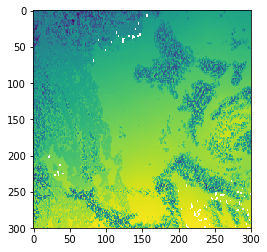

In [21]:
plt.imshow(irradiance[48,:,:])